<a href="https://colab.research.google.com/github/adindariztia/Bangkit_DiabetesPredictionML/blob/Intan/PIMA_Dataset_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
%tensorflow_version 2.x

ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

Read The Dataset

In [0]:
df = pd.read_csv('diabetes.csv')

Get a Glimpse on dataset

In [124]:
df.shape

(768, 9)

In [125]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [126]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [127]:
df.isnull().values.any()

False

In [128]:
df.Outcome.mean() #checking the distribution of Outcome, result: 35% in this dataset has Diabetes

0.3489583333333333

Create Correlation Matrix to Know Correlating Features

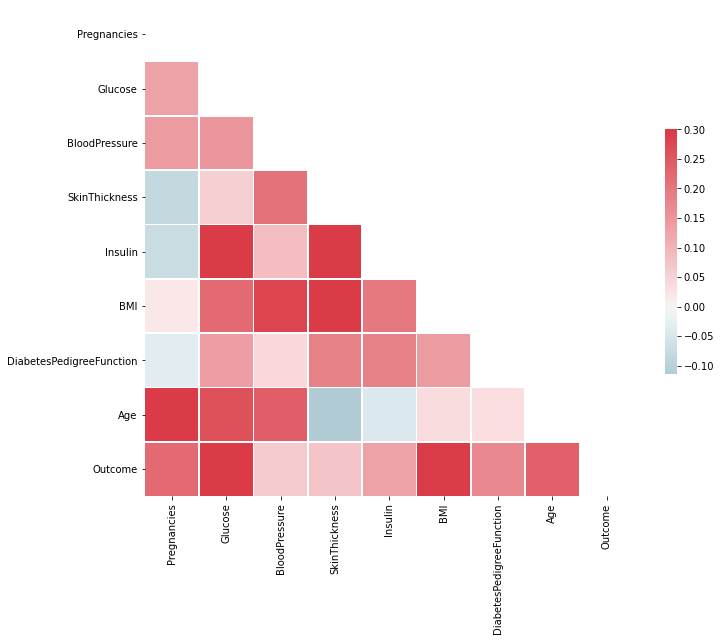

In [129]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Check missing values

In [130]:
for col in df.columns:
    print(col, df[df[col] == 0].shape[0]/df.shape[0])

Pregnancies 0.14453125
Glucose 0.006510416666666667
BloodPressure 0.045572916666666664
SkinThickness 0.2955729166666667
Insulin 0.4869791666666667
BMI 0.014322916666666666
DiabetesPedigreeFunction 0.0
Age 0.0
Outcome 0.6510416666666666


Substitute zero values in some columns

In [146]:
df_new = df.copy()
cols_to_change = ['BloodPressure', 'BMI', 'Insulin', 'SkinThickness']

for col in cols_to_change:
    mean_0 = np.mean(df.loc[(df.Outcome == 0) & (df[col] != 0) , col])
    median_0 = np.median(df.loc[(df.Outcome == 0) & (df[col] != 0), col])
    print(col, "mean: ", mean_0, "median: ", median_0)
    mean_1 = np.mean(df.loc[(df.Outcome == 1) & (df[col] != 0), col])
    median_1 = np.median(df.loc[(df.Outcome == 1) & (df[col] != 0), col])
    print(col, "mean: ", mean_1, "median: ", median_1)

    # if col != 'Insulin':
    #     df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 0), col] = mean_0
    #     df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 1), col] = mean_1
    # else:
    df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 0), col] = median_0
    df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 1), col] = median_1

BloodPressure mean:  70.87733887733887 median:  70.0
BloodPressure mean:  75.32142857142857 median:  74.5
BMI mean:  30.85967413441951 median:  30.1
BMI mean:  35.40676691729318 median:  34.3
Insulin mean:  130.28787878787878 median:  102.5
Insulin mean:  206.84615384615384 median:  169.5
SkinThickness mean:  27.235457063711912 median:  27.0
SkinThickness mean:  33.0 median:  32.0


In [0]:
#@title Insulin
#Plot distribution of Insulin, Outcome = 1 & 0, to see whether mean or median is more relevant
insulin_0 = df.loc[(df.Outcome == 0) & (df['Insulin'] != 0), 'Insulin']
insulin_1 = df.loc[(df.Outcome == 1) & (df['Insulin'] != 0), 'Insulin']
# plt.hist(insulin_0,30)
# plt.hist(insulin_1,30)

In [0]:
#@title BloodPressure
BloodPressure_0 = df.loc[(df.Outcome == 0) & (df['BloodPressure'] != 0), 'BloodPressure']
BloodPressure_1 = df.loc[(df.Outcome == 1) & (df['BloodPressure'] != 0), 'BloodPressure']
# plt.hist(BloodPressure_0,30)
# plt.hist(BloodPressure_1,30)

In [0]:
#@title BMI
BMI_0 = df.loc[(df.Outcome == 0) & (df['BMI'] != 0), 'BMI']
BMI_1 = df.loc[(df.Outcome == 1) & (df['BMI'] != 0), 'BMI']
#plt.hist(BMI_0,30)
#plt.hist(BMI_1,30)

In [0]:
#@title Skin thickness
SkinThickness_0 = df.loc[(df.Outcome == 0) & (df['SkinThickness'] != 0), 'SkinThickness']
SkinThickness_1 = df.loc[(df.Outcome == 1) & (df['SkinThickness'] != 0), 'SkinThickness']
#plt.hist(SkinThickness_0,30)
#plt.hist(SkinThickness_1,30)

Insulin: Median
BP : Mean
BMI : Mean
Must remove outliers


In [147]:
# Create an empty list that will eventually hold all created feature columns.
dataset_columns = df_new.columns
feature_columns = []

# Create numerical feature columns to represent all columns in X
for col in dataset_columns[:-1]: #Excluding outcome value, since outcome is still included in dataset
    print(col)
    col_tf = tf.feature_column.numeric_column(col)
    feature_columns.append(col_tf)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(df_new))

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age


<tf.Tensor: shape=(768, 8), dtype=float32, numpy=
array([[ 50. ,  33.6,  72. , ..., 169.5,   6. ,  35. ],
       [ 31. ,  26.6,  66. , ..., 102.5,   1. ,  29. ],
       [ 32. ,  23.3,  64. , ..., 169.5,   8. ,  32. ],
       ...,
       [ 30. ,  26.2,  72. , ..., 112. ,   5. ,  23. ],
       [ 47. ,  30.1,  60. , ..., 169.5,   1. ,  32. ],
       [ 23. ,  30.4,  70. , ..., 102.5,   1. ,  31. ]], dtype=float32)>

In [144]:
#@title create model

def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


In [139]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/700
77/77 [==============================] - 0s 1ms/step - loss: 24.2004 - accuracy: 0.3529 - precision: 0.3503 - recall: 1.0000
Epoch 2/700
77/77 [==============================] - 0s 1ms/step - loss: 8.3574 - accuracy: 0.3763 - precision: 0.3233 - recall: 0.7201
Epoch 3/700
77/77 [==============================] - 0s 1ms/step - loss: 4.9667 - accuracy: 0.4518 - precision: 0.2833 - recall: 0.3731
Epoch 4/700
77/77 [==============================] - 0s 1ms/step - loss: 4.6739 - accuracy: 0.4544 - precision: 0.2733 - recall: 0.3396
Epoch 5/700
77/77 [==============================] - 0s 1ms/step - loss: 4.3758 - accuracy: 0.4779 - precision: 0.2941 - recall: 0.3545
Epoch 6/700
77/77 [==============================] - 0s 1ms/step - loss: 4.0968 - accuracy: 0.4896 - precision: 0.3063 - recall: 0.3657
Epoch 7/700
77/77 [==============================] - 0s 1ms/step - loss: 3.8377 - accuracy: 0.4909 - precision: 0.3196 - recall: 0.4067
Epoch 8/700
77/77 [============================

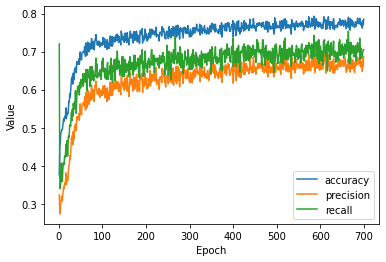

In [162]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 700
batch_size = 10
label_name = "Outcome"
classification_threshold = 0.4

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, df_new, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)